# Seasonal Model with Local Validation - LB 1.091
In this notebook we compute the validation score for "last value" baseline (from [here][1]) and the validation score for "linear regression" baseline (from [here][2]). To compute validation score, we use the last month of train data as "val data" and the first 38 months of train data as "new train data". The "last value" model has validation SMAPE = 1.101 and the "linear regression" model has SMAPE = 1.098. Discussion about validation is [here][3] and discussion summarizing the competition is [here][3]. My "linear" model is presented and explained [here][2].

In this notebook we also present a new "seasonal" model which achieves a better validation score than the "last value" model and "linear regression" model. The "seasonal" model achieves validation SMAPE = 1.095! And the "seasonal" model achieves LB 1.092 that is ranked better than "linear" model's LB 1.092. In notebook version 6 we ensemble the "seasonal" model and "linear" model and achieve `LB = 1.091` woohoo!

In notebook version 6 we use `THRESHOLD = 12` and `ACTIVE_THRESHOLD = 35_000` and our ensemble achieves `LB 1.091` and CV `1.096`. We can improve the CV to SMAPE = `1.089` using `THRESHOLD = 8` and `ACTIVE_THRESHOLD = 9_000` in notebook version 7 and 8 but unfortunately the LB is slightly worse. So CV and LB are closely related but changes in the 3rd decimal point of CV don't always correlate with the 3rd decimal of current public LB.

Note: I say "CV" but we're not doing "cross validation". We are only doing a single holdout validation. But i like to use the acronym "CV" for "local validation" even when it isn't cross validation.

[1]: https://www.kaggle.com/code/ttahara/gd-mdf-last-target-baseline
[2]: https://www.kaggle.com/code/cdeotte/linear-regression-baseline-lb-1-1
[3]: https://www.kaggle.com/competitions/godaddy-microbusiness-density-forecasting/discussion/373099

# Load Libraries, Train, Test

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# SET VALIDATE = TRUE TO COMPUTE VALIDATION. 
# AND SET VALIDATE = FALSE TO MAKE AN SUBMISSION TO LB
VALIDATE = True

# USE 1 TO VALIDATE WITH LAST MONTH OF TRAIN, 2 FOR SECOND TO LAST ETC ETC
# NEW TRAIN DATA IS EVERYTHING BEFORE THIS
VAL_MONTH = 1

In [2]:
# LOAD TRAIN DATA
train = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv')
train["first_day_of_month"] = pd.to_datetime(train["first_day_of_month"])
train = train.sort_values(['cfips','first_day_of_month']).reset_index(drop=True)

# DEFINE VALIDATION AND TRAIN MONTHS
trn_months = train.first_day_of_month.values[-39:-1*VAL_MONTH]
val_months = train.first_day_of_month.values[-1*VAL_MONTH:]
if VAL_MONTH!=1: 
    val_months = train.first_day_of_month.values[-1*VAL_MONTH:-1*VAL_MONTH+1]

# CREATE NEW TRAIN AND NEW TEST DATA IF WE ARE VALIDATING
if VALIDATE:
    test = train.loc[train.first_day_of_month.isin(val_months)]
    train = train.loc[train.first_day_of_month.isin(trn_months)]
print( train.shape )
train.head()

(119130, 7)


,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [3]:
# LOAD TEST DATA IF WE ARE NOT VALIDATING
if not VALIDATE:
    test = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv')
    test["first_day_of_month"] = pd.to_datetime(test["first_day_of_month"])
    
test = test.sort_values(['cfips','first_day_of_month']).reset_index(drop=True)
print(test.shape)
test.head()

(3135, 7)


,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2022-10-01,1001,Autauga County,Alabama,2022-10-01,3.463856,1472
1,1003_2022-10-01,1003,Baldwin County,Alabama,2022-10-01,8.359798,14320
2,1005_2022-10-01,1005,Barbour County,Alabama,2022-10-01,1.232074,244
3,1007_2022-10-01,1007,Bibb County,Alabama,2022-10-01,1.287240,229
4,1009_2022-10-01,1009,Blount County,Alabama,2022-10-01,1.831783,813


# Data EDA
Below we observe that both train and test data have 3135 unique counties (i.e. `cfips`). In the original train data, each county has 39 months of data. And in the original test data, each county expects us to predict 8 months. By displaying the `min` and `max` dates, we discover that original train data ranges from August 2019 thru October 2020 inclusive. And original test data ranges from November 2022 thru June 2023 inclusive. 

When validating, we use the last month of train (i.e. October 2020) as "new test". And the first 38 months of train as "new train". Or we can set `VAL_MONTH = 2` and use first 37 months train as "new train" and second to last month as "new test". Or we can use `VAL_MONTH = 3` etc etc. Below we plot 2 random (out of 3135) train data time series.

In [4]:
train.cfips.value_counts()

1001     38
39133    38
39089    38
39091    38
39093    38
         ..
21113    38
21115    38
21117    38
21119    38
56045    38
Name: cfips, Length: 3135, dtype: int64

In [5]:
test.cfips.value_counts()

1001     1
39133    1
39089    1
39091    1
39093    1
        ..
21113    1
21115    1
21117    1
21119    1
56045    1
Name: cfips, Length: 3135, dtype: int64

In [6]:
# COUNT MONTHS OF NEW TRAIN AND NEW TEST
TRAIN_SZ = len(train)//3135
TEST_SZ = len(test)//3135
print('New train data has',TRAIN_SZ,'months and new test data has', TEST_SZ,'months')

New train data has 38 months and new test data has 1 months


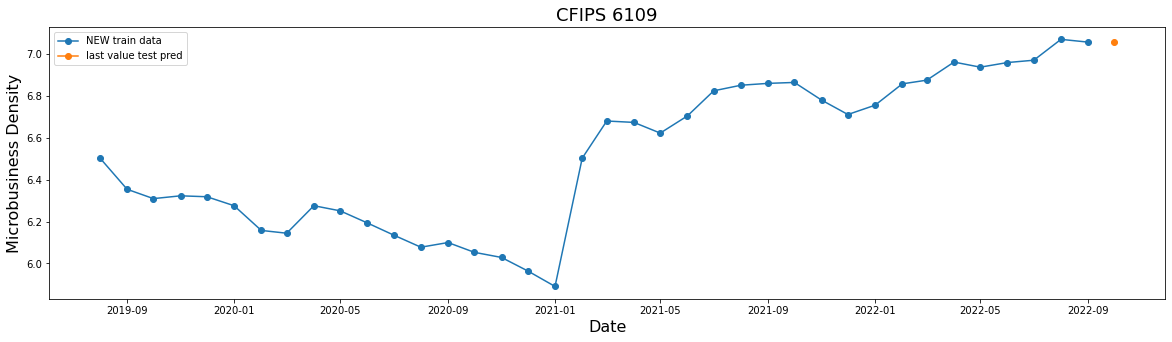

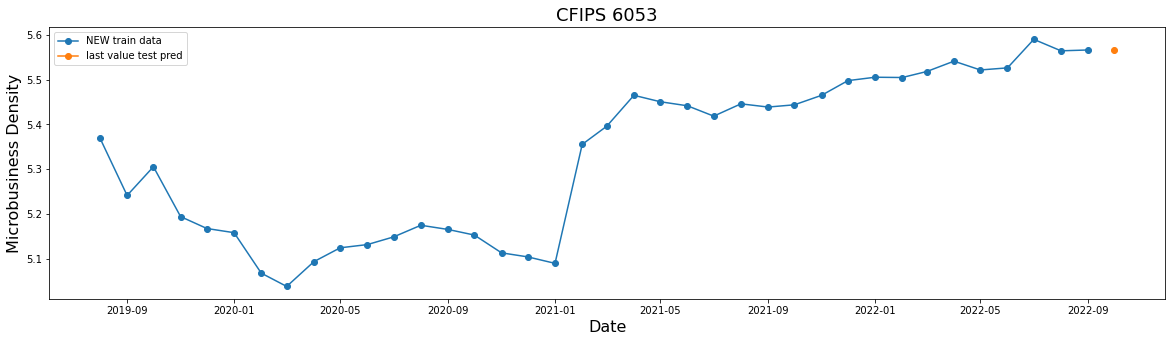

In [7]:
# PLOT RANDOM TRAIN TIME SERIES DATA
DISPLAY = 2
IDS = train.cfips.unique()
x_train = np.arange(TRAIN_SZ).reshape((-1,1))
x_test = np.arange(TRAIN_SZ-1,TRAIN_SZ+TEST_SZ).reshape((-1,1))

for i in range(DISPLAY):
    c = np.random.choice(IDS)
    df = train.loc[train.cfips==c]
    last = df.microbusiness_density.values[-1]
    preds = [last]*TEST_SZ
     
    # PLOT STUFF
    pre = ''
    if VALIDATE: pre = 'NEW '
    plt.figure(figsize=(20,5))
    plt.plot(df.first_day_of_month,df.microbusiness_density,'-o',label=f'{pre}train data')
    plt.plot(test.first_day_of_month.values[:TEST_SZ],preds,'-o',label=f'last value test pred')
    plt.title(f'CFIPS {c}',size=18)
    plt.xlabel('Date',size=16)
    plt.ylabel('Microbusiness Density',size=16)
    plt.legend()
    plt.show()
    print('\n\n')

# Train and Infer Seasonal Model
For each of 3135 time series, we look at the last 5 microbusiness_density. We also look at these 5 months 1 year previous. And we look at 2 year previous. If we see an upward trend for all three of these length 5 time series, then we predict last value times `1.003`. If we see a downward trend, we predict last value times `0.997`. We only adjust last value for counties with population greater than 35,000 (or whatever value we declare in `ACTIVE_THRESHOLD`)

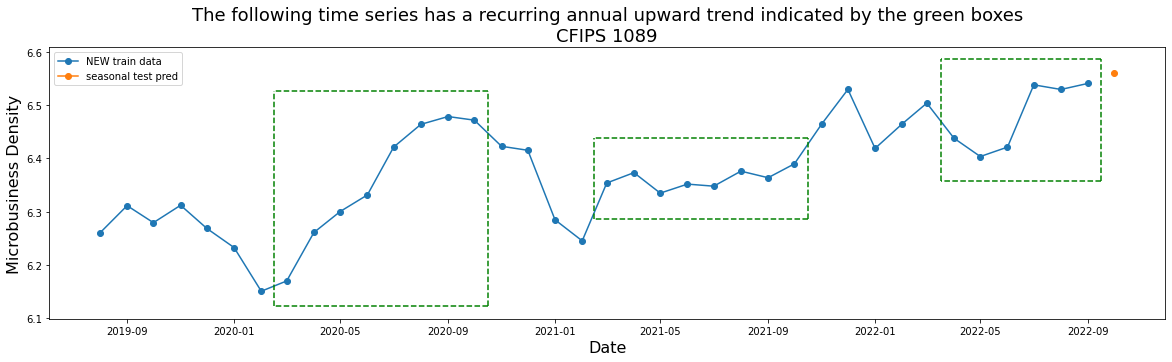

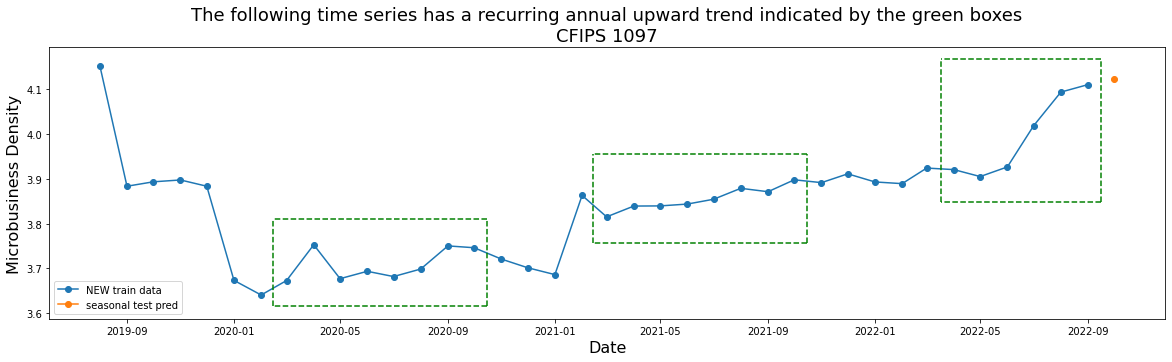

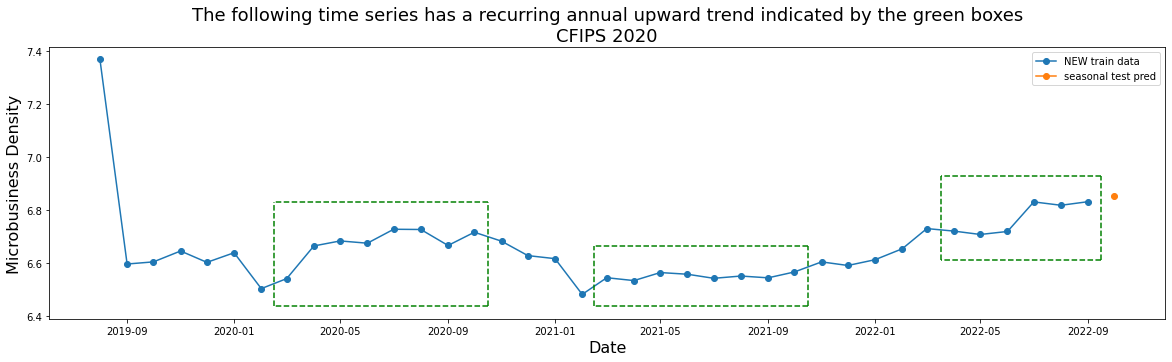

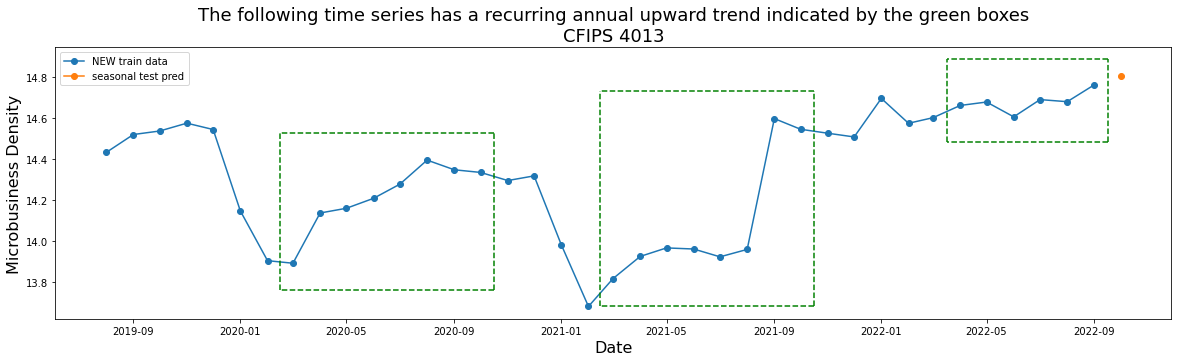

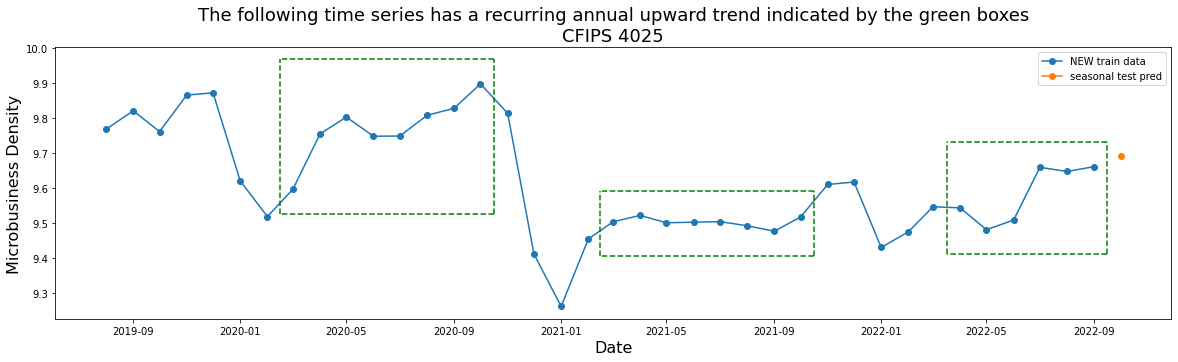

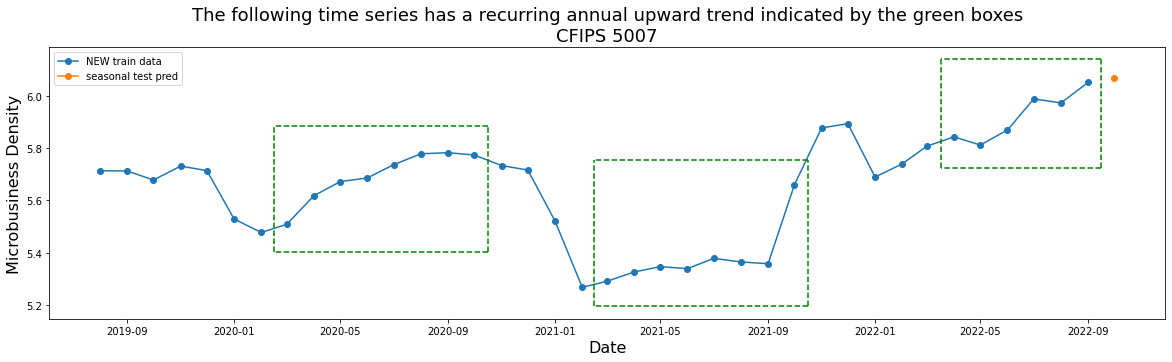

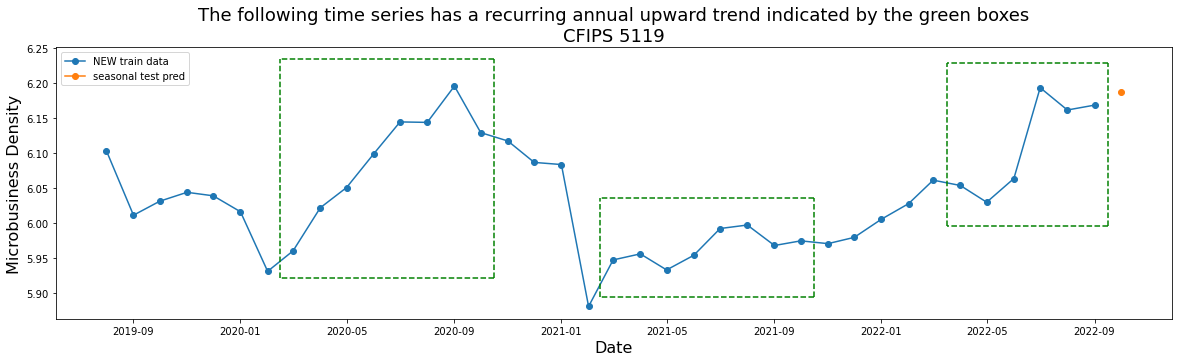

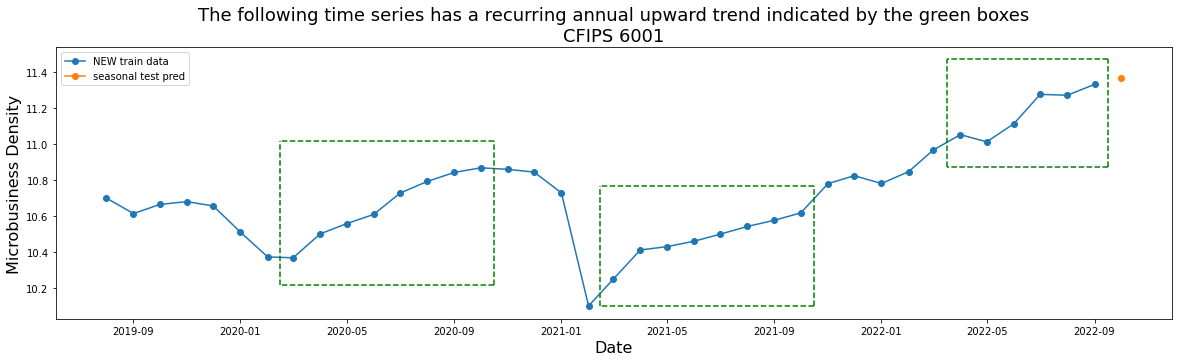




There are 63 counties with both a linear trend and large population.
There are 215 counties with both a seasonal trend and large population.


In [8]:
DISPLAY = 8
# ERROR THRESHOLD AS PERCENTAGE = THRESHOLD / 78
THRESHOLD = 8 # for linear regression
ACTIVE_THRESHOLD = 9_000

IDS = train.cfips.unique()
x_train = np.arange(TRAIN_SZ).reshape((-1,1))
x_test = np.arange(TRAIN_SZ-1,TRAIN_SZ+TEST_SZ).reshape((-1,1))

linear_preds = np.zeros((len(IDS),TEST_SZ))
last_preds = np.zeros((len(IDS),TEST_SZ))
seasonal_preds = np.zeros((len(IDS),TEST_SZ))
sn_trend = 0
lin_trend = 0

ct = 0
for i,c in enumerate(IDS):
    df = train.loc[train.cfips==c]
    last = df.microbusiness_density.values[-1]
    active = df.active.values[-1]
    last_preds[i,] = [last]*TEST_SZ
    
    # COMPUTE SEASONAL TRENDS
    WIDTH1 = 5; WIDTH2 = 7; WIDTH3 = 7
    # RECENT
    x0a = df.microbusiness_density.values[-1-WIDTH1:-1]
    x0 = np.median(x0a)
    # ONE YEAR AGO
    x1 = df.microbusiness_density.values[-12-1+1]
    x2a = df.microbusiness_density.values[-12-1-WIDTH2+1:-12-1+1]
    x2 = np.median(x2a)
    # TWO YEARS AGO
    x3 = df.microbusiness_density.values[-24-1+1]
    x4a = df.microbusiness_density.values[-24-1-WIDTH3+1:-24-1+1]
    x4 = np.median(x4a)

    # FIT TRANSFORM SEASONAL MODEL
    p = last
    if active>=ACTIVE_THRESHOLD:
        if (x1>x2)&(x3>x4)&(last>x0): p *= 1.003
        elif (x1<x2)&(x3<x4)&(last<x0): p *= 0.997
    seasonal_preds[i,] = [p]*TEST_SZ
    
    # FIT TRANSFORM LINEAR REGRESSION MODEL
    model = LinearRegression()
    model.fit(x_train,df.microbusiness_density)
    p = model.predict(x_train)
    err = p - df.microbusiness_density.values
    rng = df.microbusiness_density.max() - df.microbusiness_density.min()
    
    # DETERMINE IF TIME SERIES IS LINEAR OR NOT
    s = 0
    for k in range(TRAIN_SZ):
        e = np.abs( err[k] )
        r = e/(rng/2); s += r
    if (s>THRESHOLD)|(active<ACTIVE_THRESHOLD): 
        linear_preds[i,] = [last]*TEST_SZ
    else:    
        p2 = model.predict(x_test)
        shift =  last - p2[0]
        linear_preds[i,] = p2[1:]+shift
        lin_trend += 1
        
    # COUNT STUFF
    if seasonal_preds[i,][0] == last: continue
    ct += 1
    sn_trend += 1
    if ct>=DISPLAY+1: continue
        
    # PLOT STUFF
    plt.figure(figsize=(20,5))
    pre = ''
    if VALIDATE: pre = "NEW "
    plt.plot(df.first_day_of_month,df.microbusiness_density,'-o',label=f'{pre}train data')
    plt.plot(test.first_day_of_month.values[:TEST_SZ],seasonal_preds[i,],'-o',label=f'seasonal test pred')
    
    # DRAW BOXES AROUND DATA USED FOR SEASONAL MODEL
    for k,j in enumerate([list(x0a)+[last],list(x2a)+[x1],list(x4a)+[x3]]):
        w = [WIDTH1,WIDTH2,WIDTH3]
        last_a = np.max(j); last_b = np.min(j)
        offset = np.timedelta64(365*k,'D')
        y_diff = (plt.ylim()[1] - plt.ylim()[0])/10,
        last_d = df.first_day_of_month.values[-1] + np.timedelta64(15,'D')
        if k>0: last_d = last_d + np.timedelta64(30,'D')
        last_d2 = last_d - np.timedelta64( int((w[k]+1)*30.5),'D')
        plt.plot([last_d-offset,last_d-offset],[last_b-y_diff,last_a+y_diff],'--',color='green')
        plt.plot([last_d2-offset,last_d2-offset],[last_b-y_diff,last_a+y_diff],'--',color='green')
        plt.plot([last_d-offset,last_d2-offset],[last_b-y_diff,last_b-y_diff],'--',color='green')
        plt.plot([last_d-offset,last_d2-offset],[last_a+y_diff,last_a+y_diff],'--',color='green')
    
    mid = 'downward '
    if seasonal_preds[i,][0] > last: mid = 'upward '
    pre=f'The following time series has a recurring annual {mid}trend indicated by the green boxes\n'
    plt.title(f'{pre}CFIPS {c}',size=18)
    plt.xlabel('Date',size=16)
    plt.ylabel('Microbusiness Density',size=16)
    plt.legend()
    plt.show()
    print('\n\n')
        
# PRINT HOW MANY LINEAR TIME SERIES WE FOUND
print(f'There are {lin_trend} counties with both a linear trend and large population.')
print(f'There are {sn_trend} counties with both a seasonal trend and large population.')

# Write Submission CSV
If `VALIDATE = False`, then we write `submission.csv` below. Otherwise we write our validation predicitons to disk.

In [9]:
# NOTE TEST IS SORTED BY CFIPS AND DATA. ADD PREDS TO DATAFRAME
if VALIDATE: test['true'] = test.microbusiness_density.copy()
test['last'] = last_preds.reshape((-1))
test['linear'] = linear_preds.reshape((-1))
test['seasonal'] = seasonal_preds.reshape((-1))

# ENSEMBLE SEASONAL AND LINEAR
d1 = test.seasonal != test['last']
d2 = test.linear != test['last']
print( (d1|d2).sum() )
test['microbusiness_density'] = (test.seasonal + test.linear)/2.
test.loc[ d1 & (~d2),'microbusiness_density'] = test.loc[ d1 & (~d2),'seasonal']
test.loc[(~d1) & d2,'microbusiness_density'] = test.loc[(~d1) & d2,'linear']

# CREATE SUBMISSION CSV
sub = test[['row_id','microbusiness_density']]
if not VALIDATE: sub.to_csv('submission.csv',index=False)
else: sub.to_csv('validation.csv',index=False)
print( sub.shape )
sub.head()

226
(3135, 2)


,row_id,microbusiness_density
0,1001_2022-10-01,3.442677
1,1003_2022-10-01,8.341701
2,1005_2022-10-01,1.206827
3,1007_2022-10-01,1.315346
4,1009_2022-10-01,1.852060


# Compute Validation Scores

In [10]:
import numpy as np
def smape(y_true, y_pred):
    
    # CONVERT TO NUMPY
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # WHEN BOTH EQUAL ZERO, METRIC IS ZERO
    both = np.abs(y_true) + np.abs(y_pred)
    idx = np.where(both==0)[0]
    y_true[idx]=1; y_pred[idx]=1
    
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

## Linear Regression Model

In [11]:
if VALIDATE:
    m = smape(test.true.values, test['linear'].values)
    print('Linear model has SMAPE =',m)

Linear model has SMAPE = 1.0961507765972487


## Last Value Model

In [12]:
if VALIDATE:
    m = smape(test.true.values, test['last'].values)
    print('Last value model has SMAPE =',m)

Last value model has SMAPE = 1.1011190959563657


## Seasonal Model

In [13]:
if VALIDATE:
    m = smape(test.true.values, test['seasonal'].values)
    print('Seasonal model has SMAPE =',m)

Seasonal model has SMAPE = 1.0901294847771914


## Ensemble Model

In [14]:
if VALIDATE:
    m = smape(test.true.values, test['microbusiness_density'].values)
    print('Ensemble model has SMAPE =',m)

Ensemble model has SMAPE = 1.0890317806039536
